In [4289]:
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

load_dotenv()


True

In [4290]:
country = "UK"

if (country == "US"):
    test_type_id = [19, 20, 26]
    

if (country == "UK"):
    test_type_id = [19, 20]

test_type_id_str = ", ".join(map(str, test_type_id))

Carrier colors dictionary:

In [4291]:
carrier_color_dict = {
                        'Verizon': '#b00000',
                        'AT&T': '#067ab4',
                        'T-Mobile': '#e60076',
                        'Sprint': '#ffaa00',
                        'Dish': '#3F3F3F',
                        'EE': '#2e9b9d',
                        'O2': '#010066',
                        'Three': '#000000',
                        'Vodafone': '#f80000',
                        'O2 UK': '#010066',
                        'Three UK': '#000000',
                        'Vodafone UK': '#f80000',
                        'Sunrise': '#d0606f',
                        'Swisscom': '#5b92cc',
                        'Salt': '#56bf83',
                        'ODIDO': '#FF7621',
                        'KPN': '#FFBB00',
                        'Vodafone NL': '#f80000',
                        'KT': '#FF7621',
                        'SK Telecom': '#FFBB00',
                        'LG U+': '#f80000'
                     }

In [4292]:
carrier_color_dict_reporting = {
                                'Salt': '#1A1A1A',
                                'Sunrise': '#E6003C',
                                'Swisscom': '#001155',
                                'AT&T': '#008FCC',
                                'Sprint': '#FFAA00',
                                'T-Mobile': '#E60076',
                                'Verizon': '#B00000',
                                'EE': '#1D9F9E',
                                'O2': '#010066',
                                'Three': '#070707',
                                'Vodafone': '#F80000',
                                'KT': '#FF3333',
                                'LG U+': '#CC0066',
                                'SK Telecom': '#FF9933',
                                'Dish': '#F87217'
                            }

Network type colors dictionary:

In [4293]:
dl_color_dict = {
  '5G': '#009697', 
  'Mixed-5G': '#3CB371', 
  'LTE': '#58595b',
  'Non-LTE': '#f4a460'
}

Metadata test summary by CSDI

In [4294]:
# curr_csid = 12705
#Boston
# curr_csid = 12655
#NY
# curr_csid = 12678
#Liverpool UK
# curr_csid = 12588
# London
curr_csid = 12854

In [4295]:
ts_curr = f'''
SELECT
   date_trunc('seconds',ts.start_time)::timestamp without time zone as start_time,
   ca.time_zone,
   vcs.collection_type,
   vcs.collection_set,
   ts.collection_set_id,
   ts.test_type_id,
   c.friendly_name AS carrier,
   ts.net_types,
   ts.call_network_type, -- Note: Substitute for `co_call_network_type`
   ts.flag_access_success,
   ts.flag_task_success,
   ts.dsd_effective_download_test_speed,
   ts.dsd_throughput_max,
   ts.dsu_effective_upload_test_speed,
   ts.percentage_access_success,
   ts.percentage_task_success,
   md2.fn_get_best_network_type(ts.test_type_id, 
                                          ts.net_types, 
                                          tea.network_types, 
                                          tea.call_network_type, 
                                          tea.nr_status_filtered, 
                                          tea.nr_bearer_status_filtered,
                                          tea.nr_bearer_allocation_status_filtered,
                                          ',') AS best_network_type,
   md2.fn_get_network_types(ts.net_types, ','::character varying) AS net_types_desc,
   kt.name AS kit_type,
   rsc.name AS report_set_collector,
   (ts.start_time AT TIME ZONE 'utc' AT TIME ZONE ca.time_zone) AS local_time
FROM prod_ms_partitions.test_summary_{curr_csid} as ts
LEFT JOIN md2.collection_areas ca on (ts.collection_area_id = ca.collection_area_id)
LEFT JOIN md2.vi_collection_sets vcs on (ts.collection_set_id = vcs.collection_set_id)
LEFT JOIN md2.carriers c on (ts.carrier_id = c.carrier_id)
LEFT JOIN prod_rsr_partitions.test_event_aggr_{curr_csid} tea on (ts.collection_set_id = tea.collection_set_id and ts.test_event_id = tea.test_event_id)
LEFT JOIN md2.kit_types kt on (kt.kit_type_id = ts.kit_type_id)
LEFT JOIN md2.report_set_collectors rsc on (rsc.report_set_collector_id = ts.report_set_collector_id)
WHERE ts.test_type_id IN (19, 20, 23) 
AND ts.collection_set_period_id IS NOT NULL 
AND ts.blacklisted = FALSE 
AND ts.flag_valid = TRUE 
AND ts.carrier_id <> 478
'''

df_ts_curr  = pd.read_sql_query(ts_curr, con=os.getenv('RSR_SVC_CONN'))

# df_ts_curr.head()

Metadata test summary by COMP

In [4296]:
# comp_csid = 12381
#Boston
# comp_csid = 12331
#NY
# comp_csid = 12506
#Liverpool UK
# comp_csid = 12264
# London
comp_csid = 12265

In [4297]:
ts_comp = f'''
SELECT
   ts.start_time,
   ca.time_zone,
   vcs.collection_type,
   vcs.collection_set,
   ts.collection_set_id,
   ts.test_type_id,
   c.friendly_name as carrier,
   ts.net_types,
   ts.call_network_type, -- Note: Substitute for `co_call_network_type`
   ts.flag_access_success,
   ts.flag_task_success,
   ts.dsd_effective_download_test_speed,
   ts.dsd_throughput_max,
   ts.dsu_effective_upload_test_speed,
   ts.percentage_access_success,
   ts.percentage_task_success,
   md2.fn_get_best_network_type(ts.test_type_id, 
                                          ts.net_types, 
                                          tea.network_types, 
                                          tea.call_network_type, 
                                          tea.nr_status_filtered, 
                                          tea.nr_bearer_status_filtered,
                                          tea.nr_bearer_allocation_status_filtered,
                                          ','
                                          ) best_network_type,
   md2.fn_get_network_types(ts.net_types, ','::character varying) AS net_types_desc,
   kt.name AS kit_type,
   rsc.name as report_set_collector,
   (start_time at time zone 'utc' at time zone ca.time_zone) as local_time
FROM prod_ms_partitions.test_summary_{comp_csid} ts
LEFT JOIN md2.collection_areas ca on (ts.collection_area_id = ca.collection_area_id)
LEFT JOIN md2.vi_collection_sets vcs on (ts.collection_set_id = vcs.collection_set_id)
LEFT JOIN md2.carriers c on (ts.carrier_id = c.carrier_id)
LEFT JOIN prod_rsr_partitions.test_event_aggr_{comp_csid} tea on (ts.collection_set_id = tea.collection_set_id and ts.test_event_id = tea.test_event_id)
LEFT JOIN md2.kit_types kt on (kt.kit_type_id = ts.kit_type_id)
LEFT JOIN md2.report_set_collectors rsc on (rsc.report_set_collector_id = ts.report_set_collector_id)
WHERE c.friendly_name NOT IN ('Sprint') 
AND ts.test_type_id IN (19, 20, 23) 
AND ts.collection_set_period_id IS NOT NULL 
AND ts.blacklisted = FALSE and ts.flag_valid = TRUE 
AND ts.carrier_id <> 478
'''

df_ts_comp = pd.read_sql_query(ts_comp, con=os.getenv('RSR_SVC_CONN'))

# df_ts_comp.head()

DQ test counts

In [4298]:
test_count = f'''
SELECT * 
FROM analytic.fn_dq_test_counts({curr_csid}) 
'''

df_test_count = pd.read_sql_query(test_count, con=os.getenv('RSR_SVC_CONN'))

# df_test_count.head()

DL Network Category

Current:

In [4299]:
dl_5g_curr = f'''
WITH best_network_type AS (
    SELECT 
        pro.product_period, 
        c.friendly_name AS carrier, 
        md2.fn_get_best_network_type(
            ts.test_type_id, 
            ts.net_types, 
            tea.network_types, 
            tea.call_network_type, 
            tea.nr_status_filtered, 
            tea.nr_bearer_status_filtered,
            tea.nr_bearer_allocation_status_filtered,
            ','
        ) AS best_network_type,
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success
    FROM prod_rsr_partitions.test_event_aggr_{curr_csid} tea
    JOIN prod_ms_partitions.test_summary_{curr_csid} ts USING (test_event_id)
    JOIN md2.carriers c ON (c.carrier_id = ts.carrier_id)
    JOIN md2.product_periods pro USING (product_period_id)
    WHERE c.friendly_name NOT IN ('Dish') 
      AND ts.blacklisted = FALSE 
      AND ts.flag_valid = TRUE 
      AND ts.collection_set_period_id IS NOT NULL 
      AND ts.test_type_id IN (20)
),
data_network_category AS (
    SELECT 
        product_period, 
        carrier, 
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success,
        CASE 
            WHEN best_network_type IN ('NR SA', 'NR NSA') THEN '5G' 
            WHEN best_network_type IN ('NR SA, LTE', 'NR NSA, LTE') THEN 'Mixed-5G' 
            WHEN best_network_type IN ('LTE') THEN 'LTE'
            ELSE 'Non-LTE' 
        END AS dl_network
    FROM best_network_type
)
SELECT product_period,
        carrier,
        dl_network,
        COUNT(*) AS count,
        ROUND(100 * count(*) / sum(count(*)) over (partition by carrier),2) as dl_pct,
        ROUND(median(dsd_access_speed_median)::numeric,0) as access_spd,
        ROUND(cast(median(dsd_effective_download_test_speed)/1000 as numeric),1) as med_tput,
        ROUND(cast(max(dsd_effective_download_test_speed)/1000 as numeric),1) as max_tput,
        ROUND(cast(max(dsd_throughput_max)/1000 as numeric),1) as burst_tput,
        ROUND(cast(avg(percentage_access_success) * 100 as numeric),1) as access,
        ROUND(cast(avg(percentage_task_success) * 100 as numeric),1) as task
FROM data_network_category
Where carrier not in ('Dish')
GROUP BY product_period, carrier, dl_network
ORDER BY carrier, case when dl_network = '5G' then 1 when dl_network = 'Mixed-5G' then 2 when dl_network = 'LTE' then 3 when dl_network = 'Non-LTE' then 4 end
'''
df_dl_5g_curr = pd.read_sql_query(dl_5g_curr, con=os.getenv('RSR_SVC_CONN'))

# df_dl_5g_curr.head()

Comparisson

In [4300]:
dl_5g_comp = f'''
WITH best_network_type AS (
    SELECT 
        pro.product_period, 
        c.friendly_name AS carrier, 
        md2.fn_get_best_network_type(
            ts.test_type_id, 
            ts.net_types, 
            tea.network_types, 
            tea.call_network_type, 
            tea.nr_status_filtered, 
            tea.nr_bearer_status_filtered,
            tea.nr_bearer_allocation_status_filtered,
            ','
        ) AS best_network_type,
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success
    FROM prod_rsr_partitions.test_event_aggr_{comp_csid} tea
    JOIN prod_ms_partitions.test_summary_{comp_csid} ts USING (test_event_id)
    JOIN md2.carriers c ON (c.carrier_id = ts.carrier_id)
    JOIN md2.product_periods pro USING (product_period_id)
    WHERE c.friendly_name NOT IN ('Dish') 
      AND ts.blacklisted = FALSE 
      AND ts.flag_valid = TRUE 
      AND ts.collection_set_period_id IS NOT NULL 
      AND ts.test_type_id IN (20)
),
data_network_category AS (
    SELECT 
        product_period, 
        carrier, 
        dsd_access_speed_median, 
        dsd_effective_download_test_speed, 
        dsd_throughput_max, 
        percentage_access_success, 
        percentage_task_success,
        CASE 
            WHEN best_network_type IN ('NR SA', 'NR NSA') THEN '5G' 
            WHEN best_network_type IN ('NR SA, LTE', 'NR NSA, LTE') THEN 'Mixed-5G' 
            WHEN best_network_type IN ('LTE') THEN 'LTE'
            ELSE 'Non-LTE' 
        END AS dl_network
    FROM best_network_type
)
SELECT product_period,
        carrier,
        dl_network,
        COUNT(*) AS count,
        ROUND(100 * count(*) / sum(count(*)) over (partition by carrier),2) as dl_pct,
        ROUND(median(dsd_access_speed_median)::numeric,0) as access_spd,
        ROUND(cast(median(dsd_effective_download_test_speed)/1000 as numeric),1) as med_tput,
        ROUND(cast(max(dsd_effective_download_test_speed)/1000 as numeric),1) as max_tput,
        ROUND(cast(max(dsd_throughput_max)/1000 as numeric),1) as burst_tput,
        ROUND(cast(avg(percentage_access_success) * 100 as numeric),1) as access,
        ROUND(cast(avg(percentage_task_success) * 100 as numeric),1) as task
FROM data_network_category
Where carrier not in ('Dish')
GROUP BY product_period, carrier, dl_network
ORDER BY carrier, case when dl_network = '5G' then 1 when dl_network = 'Mixed-5G' then 2 when dl_network = 'LTE' then 3 when dl_network = 'Non-LTE' then 4 end
'''
df_dl_5g_comp = pd.read_sql_query(dl_5g_comp, con=os.getenv('RSR_SVC_CONN'))

# df_dl_5g_comp.head()

Data Network Category (Download, Upload, LDRs)

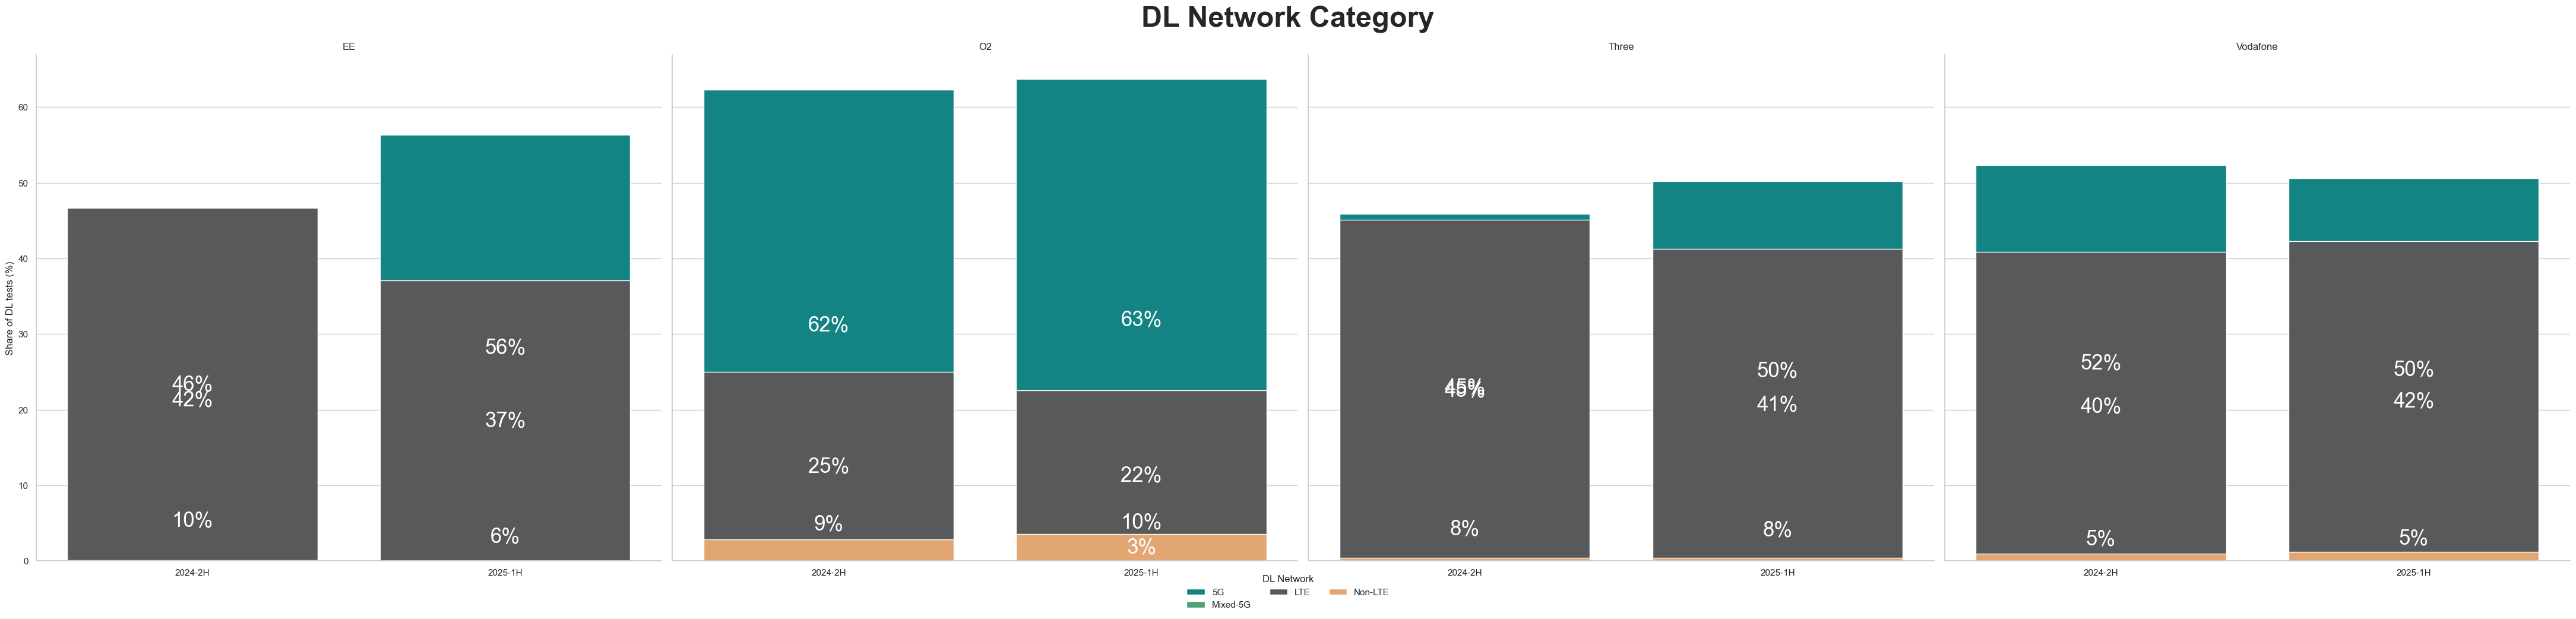

In [4301]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Add a column to distinguish between current and comparison data

df_dl_5g_curr["product_period"] = df_dl_5g_curr["product_period"]
df_dl_5g_comp["product_period"] = df_dl_5g_comp["product_period"]

# Combine the two DataFrames
df_dl_5g_combined = pd.concat([df_dl_5g_comp,df_dl_5g_curr], ignore_index=True)

# Create FacetGrid
g = sns.FacetGrid(df_dl_5g_combined, col="carrier", col_wrap=4, height=10, sharey=True)

# Map bar plots
g.map_dataframe(sns.barplot, x="product_period", y="dl_pct", hue="dl_network",
                palette=dl_color_dict, dodge=False, errorbar=None)

# Add text labels to bars (only for current data)
for ax, (_, subdata) in zip(g.axes.flat, df_dl_5g_curr.groupby("carrier")):
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height >= 3:
                ax.text(bar.get_x() + bar.get_width() / 2., height / 2,
                        f'{int(height)}%', ha='center', va='center', color='white', fontsize=25)

# Customize layout
g.set_axis_labels("", "Share of DL tests (%)")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("DL Network Category", fontsize=35, fontweight='bold')
g.add_legend(title="DL Network", bbox_to_anchor=(0.5, -0.05), loc='lower center', ncol=3)
plt.tight_layout()
plt.show()



# df_dl_5g_combined.head(len(df_dl_5g_combined))

Display table only for current:

In [4302]:
df_dl_5g_curr.head(len(df_dl_5g_curr))

,product_period,carrier,dl_network,count,dl_pct,access_spd,med_tput,max_tput,burst_tput,access,task
0,2025-1H,EE,5G,1686,56.35,29.0,298.5,944.1,1036.8,100.0,100.0
1,2025-1H,EE,Mixed-5G,194,6.48,32.0,94.0,607.6,835.1,99.9,95.5
2,2025-1H,EE,LTE,1110,37.10,30.0,54.6,441.1,671.4,98.9,99.0
3,2025-1H,EE,Non-LTE,2,0.07,3099.0,2.8,2.8,9.8,31.3,33.3
4,2025-1H,O2,5G,1908,63.75,32.0,84.4,475.6,651.4,99.7,98.6
5,2025-1H,O2,Mixed-5G,303,10.12,40.0,16.3,211.4,342.2,97.3,91.4
6,2025-1H,O2,LTE,675,22.55,35.0,18.5,260.6,374.7,97.3,95.1
7,2025-1H,O2,Non-LTE,107,3.58,79.0,0.9,19.2,111.7,74.0,67.0
8,2025-1H,Three,5G,1502,50.20,19.0,243.6,1408.7,1477.9,100.0,99.9
9,2025-1H,Three,Mixed-5G,243,8.12,31.0,53.5,854.8,1214.6,99.6,95.9


Current:

In [4303]:
network_category_curr = f'''
with best_network_type as (
  select pro.product_period, c.friendly_name as carrier,
  md2.fn_get_best_network_type(ts.test_type_id, ts.net_types, tea.network_types, tea.call_network_type, tea.nr_status_filtered, tea.nr_bearer_status_filtered,tea.nr_bearer_allocation_status_filtered,',') best_network_type
  from prod_rsr_partitions.test_event_aggr_{curr_csid} tea
  join prod_ms_partitions.test_summary_{curr_csid} ts using (test_event_id)
  join md2.carriers c on (c.carrier_id = ts.carrier_id)
  join md2.product_periods pro using(product_period_id)
  where c.friendly_name NOT IN ('Dish') 
  AND  ts.blacklisted = false and ts.flag_valid = true and ts.collection_set_period_id is not null 
  and ts.test_type_id in ({test_type_id_str})
),
data_network_category as (
select product_period, carrier,
    case when best_network_type in ('NR SA','NR NSA') then '5G'
    when best_network_type in ('NR SA, LTE','NR NSA, LTE') then 'Mixed-5G'
      when best_network_type in ('LTE') then 'LTE'
    else 'Non-LTE' end as network
from best_network_type
)
select product_period, carrier, network, count(*) as count, round(100 * count(*) / sum(count(*)) over (partition by carrier),1) as percent
from data_network_category
group by product_period, carrier, network
order by carrier, case when network = '5G' then 1 when network = 'Mixed-5G' then 2 when network = 'LTE' then 3 when network = 'Non-LTE' then 4 end
'''

df_network_category_curr = pd.read_sql_query(network_category_curr, con=os.getenv('RSR_SVC_CONN'))

df_network_category_curr.head()

,product_period,carrier,network,count,percent
0,2025-1H,EE,5G,3351,55.7
1,2025-1H,EE,Mixed-5G,420,7.0
2,2025-1H,EE,LTE,2235,37.2
3,2025-1H,EE,Non-LTE,6,0.1
4,2025-1H,O2,5G,3798,63.2


Comparisson:

In [4304]:
network_category_comp = f'''
with best_network_type as (
  select pro.product_period, c.friendly_name as carrier,
  md2.fn_get_best_network_type(ts.test_type_id, ts.net_types, tea.network_types, tea.call_network_type, tea.nr_status_filtered, tea.nr_bearer_status_filtered,tea.nr_bearer_allocation_status_filtered,',') best_network_type
  from prod_rsr_partitions.test_event_aggr_{comp_csid} tea
  join prod_ms_partitions.test_summary_{comp_csid} ts using (test_event_id)
  join md2.carriers c on (c.carrier_id = ts.carrier_id)
  join md2.product_periods pro using(product_period_id)
  where c.friendly_name NOT IN ('Dish') 
  AND  ts.blacklisted = false and ts.flag_valid = true 
  and ts.collection_set_period_id is not null 
  and ts.test_type_id in ({test_type_id_str})
),
data_network_category as (
select product_period, carrier,
    case when best_network_type in ('NR SA','NR NSA') then '5G'
    when best_network_type in ('NR SA, LTE','NR NSA, LTE') then 'Mixed-5G'
      when best_network_type in ('LTE') then 'LTE'
    else 'Non-LTE' end as network
from best_network_type
)
select product_period, carrier, network, count(*) as count, round(100 * count(*) / sum(count(*)) over (partition by carrier),1) as percent
from data_network_category
group by product_period, carrier, network
order by carrier, case when network = '5G' then 1 when network = 'Mixed-5G' then 2 when network = 'LTE' then 3 when network = 'Non-LTE' then 4 end
'''
df_network_category_comp = pd.read_sql_query(network_category_comp, con=os.getenv('RSR_SVC_CONN'))

df_network_category_comp.head(len(df_network_category_comp))

,product_period,carrier,network,count,percent
0,2024-2H,EE,5G,2552,43.5
1,2024-2H,EE,Mixed-5G,677,11.5
2,2024-2H,EE,LTE,2635,44.9
3,2024-2H,EE,Non-LTE,8,0.1
4,2024-2H,O2,5G,3623,61.7
5,2024-2H,O2,Mixed-5G,613,10.4
6,2024-2H,O2,LTE,1454,24.7
7,2024-2H,O2,Non-LTE,186,3.2
8,2024-2H,Three,5G,2725,46.4
9,2024-2H,Three,Mixed-5G,489,8.3


Data Network Category filtered and reshape by network type

In [4305]:
# Combine the current and comparison DataFrames
df_network_category_combined = pd.concat([df_network_category_curr, df_network_category_comp], ignore_index=True)

# Reshape the DataFrame
df_network_category_reshaped = df_network_category_combined.pivot_table(
    index=["product_period", "carrier"], 
    columns="network", 
    values="percent"
).reset_index()

# Remove the column index name
df_network_category_reshaped.columns.name = None  

# Sort by 'carrier'
df_network_category_reshaped = df_network_category_reshaped.sort_values(by="carrier").reset_index(drop=True)

# Reorder  the columns
df_network_category_reshaped = df_network_category_reshaped[['product_period', 'carrier', '5G', 'Mixed-5G', 'LTE']]

# Display the entire DataFrame
df_network_category_reshaped.head(len(df_network_category_reshaped))

,product_period,carrier,5G,Mixed-5G,LTE
0,2024-2H,EE,43.5,11.5,44.9
1,2025-1H,EE,55.7,7.0,37.2
2,2024-2H,O2,61.7,10.4,24.7
3,2025-1H,O2,63.2,10.0,23.3
4,2024-2H,Three,46.4,8.3,44.9
5,2025-1H,Three,49.1,8.5,41.9
6,2024-2H,Vodafone,52.1,6.9,40.1
7,2025-1H,Vodafone,51.8,6.9,40.1


                                    Download Network Technology

In [4306]:
dl_lte_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]
dl_lte_curr['start_date'] = pd.to_datetime(dl_lte_curr['local_time']).dt.date

dl_lte_comp = df_ts_comp [df_ts_comp ['test_type_id'] == 20]
dl_lte_comp['start_date'] = pd.to_datetime(dl_lte_comp['local_time']).dt.date


filtered_net_type_curr = (
    dl_lte_curr['net_types'].isin([262144, 4194304, 4456448]) & 
    dl_lte_curr['net_types_desc'].isin(["LTE", "Mixed", "5G", "NR", "LTE,NR"]))
   
filtered_net_type_comp = (
    dl_lte_comp['net_types'].isin([262144, 4194304, 4456448]) & 
    dl_lte_comp['net_types_desc'].isin(["LTE", "Mixed", "5G", "NR", "LTE,NR"])
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1111104769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_lte_curr['start_date'] = pd.to_datetime(dl_lte_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1111104769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_lte_comp['start_date'] = pd.to_datetime(dl_lte_comp['local_time']).dt.date


                                            DL LTE market Daily

Current:

In [4307]:
lte_1 = (
    dl_lte_curr[filtered_net_type_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='lte_count') 
)

lte_2 = (
    dl_lte_curr
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_curr = pd.merge(lte_1, lte_2, on=['carrier', 'start_date'], how='left').fillna(0)

lte_curr['lte_pct'] = round((lte_curr['lte_count'] / lte_curr['total_tests']) * 100, 2)

# lte_curr.head()

Comparison:

In [4308]:

lte_3 = (
    dl_lte_comp[filtered_net_type_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='lte_count') 
)

lte_4 = (
    dl_lte_comp
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_comp = pd.merge(lte_3, lte_4, on=['carrier', 'start_date'], how='left').fillna(0)

lte_comp['lte_pct'] = round((lte_comp['lte_count'] / lte_comp['total_tests']) * 100, 2)

# lte_comp.head()

                                                DL LTE Overall

Current:

In [4309]:
lte_5 = (
    dl_lte_curr[filtered_net_type_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='lte_count')
)

lte_6 = (
    dl_lte_curr
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_all_curr = pd.merge(lte_5, lte_6, on=['carrier'], how='left').fillna(0)

lte_all_curr['mean_LTE_curr'] = round((lte_all_curr['lte_count'] / lte_all_curr['total_tests']) * 100, 2)

# lte_all_curr.head()

Comparison:

In [4310]:
lte_7 = (
    dl_lte_comp[filtered_net_type_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='lte_count')
)

lte_8 = (
    dl_lte_comp
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

lte_all_comp = pd.merge(lte_7, lte_8, on=['carrier'], how='left').fillna(0)

lte_all_comp['mean_LTE_comp'] = round((lte_all_comp['lte_count'] / lte_all_comp['total_tests']) * 100, 2)

# lte_all_comp.head()

PLOT GRAPH

In [4311]:
# def plot_with_summary(data, color, **kwargs):
#     import matplotlib.pyplot as plt

#     carrier = data['carrier'].iloc[0]  

#     # Plot the line for daily LTE percentage
#     sns.lineplot(
#         data=data,
#         x="start_date",
#         y="lte_pct",
#         marker="o",
#         color=carrier_color_dict_reporting.get(carrier, "gray"),
#         linewidth=3,
#         markersize=10,
#         **kwargs
#     )

#     # Add summary lines
#     mean_curr_vals = lte_all_curr[lte_all_curr['carrier'] == carrier]['mean_LTE_curr']
#     if not mean_curr_vals.empty:
#         mean_curr = mean_curr_vals.mean()
#         plt.axhline(
#             y=mean_curr,
#             color="blue",
#             linewidth=2,
#             linestyle="-"
#         )

#     mean_comp_vals = lte_all_comp[lte_all_comp['carrier'] == carrier]['mean_LTE_comp']
#     if not mean_comp_vals.empty:
#         mean_comp = mean_comp_vals.mean()
#         plt.axhline(
#             y=mean_comp,
#             color="yellow",
#             linewidth=2,
#             linestyle="-"
#         )

#     min_vals = lte_comp[lte_comp['carrier'] == carrier]['lte_pct']
#     if not min_vals.empty:
#         min_val = min_vals.min()
#         plt.axhline(
#             y=min_val,
#             color="#686868",
#             linewidth=1,
#             linestyle="dashed"
#         )

# g = sns.FacetGrid(
#     lte_curr,
#     col="carrier",
#     col_wrap=3,
#     height=4,
#     sharey=True
# )

# g.map_dataframe(plot_with_summary)

# g.set_titles(col_template="{col_name}")
# g.set_axis_labels("", "DL Network Technology (%)")
# g.set(ylim=(-5, 130))

# # Adjust the x-axis tick labels (dates)
# for ax in g.axes.flat:
#     ax.tick_params(axis='x', labelsize=8)  
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

# plt.subplots_adjust(top=0.9)
# g.fig.suptitle("DL Network Technology", fontsize=18, fontweight="bold")


# # Create custom legend handles
# mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
# mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
# min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# # Add to the figure legend (not individual subplots)
# g.add_legend()  
# g.fig.legend(
#     handles=[mean_curr_line, mean_comp_line, min_comp_line],
#     loc='upper right',
#     bbox_to_anchor=(0.99, 0.99),
#     fontsize=6,
#     frameon=True,
#     edgecolor='black'
# )
# plt.tight_layout()
# plt.show()


Compute the EOM table

In [4312]:
#Merge and select columns
lte_rate = pd.merge(lte_all_curr, lte_all_comp, on='carrier', how='outer')
lte_rate = lte_rate.drop(columns=['lte_count_x', 'lte_count_y', 'total_tests_x', 'total_tests_y'])

#Delta
lte_rate['delta'] = (lte_rate['mean_LTE_curr'] - lte_rate['mean_LTE_comp'])

#Calculate percentage change
lte_rate['pct_change'] = round(((lte_rate['mean_LTE_curr'] - lte_rate['mean_LTE_comp']) / lte_rate['mean_LTE_comp']) * 100, 2)

#Add measure column
lte_rate['measure'] = 'DL Network Technology (%)'

#Reorder columns
lte_rate = lte_rate[['measure', 'carrier', 'mean_LTE_curr', 'mean_LTE_comp', 'delta', 'pct_change']]

#Rename columns
lte_rate = lte_rate.rename(columns={
    'mean_LTE_curr': 'current',
    'mean_LTE_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

lte_rate.head()

,measure,carrier,current,comparison,delta,% pct_change
0,DL Network Technology (%),EE,99.93,99.86,0.07,0.07
1,DL Network Technology (%),O2,96.39,97.10,-0.71,-0.73
2,DL Network Technology (%),Three,99.57,99.56,0.01,0.01
3,DL Network Technology (%),Vodafone,98.76,99.01,-0.25,-0.25


                                                    M2M VoLTE/VoNR/EPS Fallback

In [4313]:
call_data_curr = df_ts_curr[df_ts_curr['test_type_id'] == 23]
call_data_curr['start_date'] = pd.to_datetime(call_data_curr['local_time']).dt.date

filtered_call_net_type_curr = (
    call_data_curr['call_network_type'].isin(["VoLTE", "EPS Fallback", "VoNR"]) 
)

call_data_comp = df_ts_comp[df_ts_comp['test_type_id'] == 23]
call_data_comp['start_date'] = pd.to_datetime(call_data_comp['local_time']).dt.date

filtered_call_net_type_comp = (
    call_data_comp['call_network_type'].isin(["VoLTE", "EPS Fallback", "VoNR"]) 
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1874461607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['start_date'] = pd.to_datetime(call_data_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1874461607.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_comp['start_date'] = pd.to_datetime(call_data_comp['local_time']).dt.date


In [4314]:
# call_data_curr.head()

Current VoLTE:

In [4315]:
volte_1 = (
    call_data_curr[filtered_call_net_type_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_2 = (
    call_data_curr
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

volte_curr = pd.merge(volte_1, volte_2, on=['carrier', 'start_date'], how='left').fillna(0)

volte_curr['volte_pct'] = round((volte_curr['volte_count'] / volte_curr['total_tests']) * 100, 2)

# volte_curr.head()

Comparison VoLTE:

In [4316]:
volte_3 = (
    call_data_comp[filtered_call_net_type_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_4 = (
    call_data_comp
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

volte_comp = pd.merge(volte_3, volte_4, on=['carrier', 'start_date'], how='left').fillna(0)

volte_comp['volte_pct'] = round((volte_comp['volte_count'] / volte_comp['total_tests']) * 100, 2)

# volte_comp.head()

                                                    DL LTE Overall

Current:

In [4317]:
volte_5 = (
    call_data_curr[filtered_call_net_type_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_6 = (
    call_data_curr
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

volte_all_curr = pd.merge(volte_5, volte_6, on=['carrier'], how='left').fillna(0)

volte_all_curr['mean_voLTE_curr'] = round((volte_all_curr['volte_count'] / volte_all_curr['total_tests']) * 100, 2)

# volte_all_curr.head()

Comparison:

In [4318]:
volte_7 = (
    call_data_comp[filtered_call_net_type_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='volte_count')
)

volte_8 = (
    call_data_comp
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')  
)

volte_all_comp = pd.merge(volte_7, volte_8, on=['carrier'], how='left').fillna(0)

volte_all_comp['mean_voLTE_comp'] = round((volte_all_comp['volte_count'] / volte_all_comp['total_tests']) * 100, 2)

# volte_all_comp.head()

PLOT GRAPH

In [4319]:
# def plot_with_fallback(data, color, **kwargs):
#     import matplotlib.pyplot as plt

#     carrier = data['carrier'].iloc[0]  

#     # Plot the line for daily LTE percentage
#     sns.lineplot(
#         data=data,
#         x="start_date",
#         y="volte_pct",
#         marker="o",
#         color=carrier_color_dict_reporting.get(carrier, "gray"),
#         linewidth=3,
#         markersize=10,
#         **kwargs
#     )

#     # Add summary lines
#     mean_curr_vals = volte_all_curr[volte_all_curr['carrier'] == carrier]['mean_voLTE_curr']
#     if not mean_curr_vals.empty:
#         mean_curr = mean_curr_vals.mean()
#         plt.axhline(
#             y=mean_curr,
#             color="blue",
#             linewidth=2,
#             linestyle="-"
#         )

#     mean_comp_vals = volte_all_comp[volte_all_comp['carrier'] == carrier]['mean_voLTE_comp']
#     if not mean_comp_vals.empty:
#         mean_comp = mean_comp_vals.mean()
#         plt.axhline(
#             y=mean_comp,
#             color="yellow",
#             linewidth=2,
#             linestyle="-"
#         )

#     min_vals = volte_comp[volte_comp['carrier'] == carrier]['volte_pct']
#     if not min_vals.empty:
#         min_val = min_vals.min()
#         plt.axhline(
#             y=min_val,
#             color="#686868",
#             linewidth=1,
#             linestyle="dashed"
#         )

# g = sns.FacetGrid(
#     volte_curr,
#     col="carrier",
#     col_wrap=3,
#     height=4,
#     sharey=True
# )

# g.map_dataframe(plot_with_fallback)

# g.set_titles(col_template="{col_name}")
# g.set_axis_labels("", "Call Network Type (%)")
# g.set(ylim=(-5, 130))

# # Adjust the x-axis tick labels (dates)
# for ax in g.axes.flat:
#     ax.tick_params(axis='x', labelsize=8)  
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

# plt.subplots_adjust(top=0.9)
# g.fig.suptitle("VoLTE/VoNR/EPS Fallback", fontsize=18, fontweight="bold")


# # Create custom legend handles
# mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
# mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
# min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# # Add to the figure legend (not individual subplots)
# g.add_legend()  
# g.fig.legend(
#     handles=[mean_curr_line, mean_comp_line, min_comp_line],
#     loc='upper right',
#     bbox_to_anchor=(0.99, 0.99),
#     fontsize=6,
#     frameon=True,
#     edgecolor='black'
# )
# plt.tight_layout()
# plt.show()


compute the EOM table

In [4320]:
#Merge and select columns
volte_rate = pd.merge(volte_all_curr, volte_all_comp, on='carrier', how='outer')
volte_rate = volte_rate.drop(columns=['volte_count_x', 'volte_count_y', 'total_tests_x', 'total_tests_y'])

#Delta
volte_rate['delta'] = (volte_rate['mean_voLTE_curr'] - volte_rate['mean_voLTE_comp'])

#Calculate percentage change
volte_rate['pct_change'] = round(((volte_rate['mean_voLTE_curr'] - volte_rate['mean_voLTE_comp']) / volte_rate['mean_voLTE_comp']) * 100, 2)

#Add measure column
volte_rate['measure'] = 'Call Network Type (%)'

#Reorder columns
volte_rate = volte_rate[['measure', 'carrier', 'mean_voLTE_curr', 'mean_voLTE_comp', 'delta', 'pct_change']]

#Rename columns
volte_rate = volte_rate.rename(columns={
    'mean_LTE_curr': 'current',
    'mean_LTE_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

volte_rate.head()

,measure,carrier,mean_voLTE_curr,mean_voLTE_comp,delta,% pct_change
0,Call Network Type (%),EE,99.81,99.61,0.20,0.20
1,Call Network Type (%),O2,96.12,95.38,0.74,0.78
2,Call Network Type (%),Three,99.16,98.72,0.44,0.45
3,Call Network Type (%),Vodafone,96.04,95.07,0.97,1.02


                                Mobile-to-Mobile Call Block

In [4321]:
call_data_curr['blocked_call'] = 0
mask =(call_data_curr['flag_access_success'] == False)
call_data_curr.loc[mask, 'blocked_call'] = 1

filtered_call_block_curr = (
    call_data_curr['blocked_call'] == 1
)

call_data_comp['blocked_call'] = 0
mask =(call_data_comp['flag_access_success'] == False)
call_data_comp.loc[mask, 'blocked_call'] = 1

filtered_call_block_comp = (
    call_data_comp['blocked_call'] == 1
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2479447700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['blocked_call'] = 0
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2479447700.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_comp['blocked_call'] = 0


M2M Block Rate Current market Daily

In [4322]:
blk_1 = (
    call_data_curr[filtered_call_block_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_2 = (
    call_data_curr
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_curr = pd.merge(blk_1, blk_2, on=['carrier', 'start_date'], how='right').fillna(0)

block_curr['block_pct'] = round((block_curr['block_count'] / block_curr['total_tests']) * 100, 2)

block_curr = block_curr[['carrier', 'start_date', 'block_count', 'total_tests', 'block_pct']]

# block_curr.head(len(block_curr))

M2M Block Rate Comparison market Daily

In [4323]:
blk_3 = (
    call_data_comp[filtered_call_block_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_4 = (
    call_data_comp
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_comp = pd.merge(blk_3, blk_4, on=['carrier', 'start_date'], how='right').fillna(0)

block_comp['block_pct'] = round((block_comp['block_count'] / block_comp['total_tests']) * 100, 2)

block_comp = block_comp[['carrier', 'start_date', 'block_count', 'total_tests', 'block_pct']]

# block_comp.head()

                                                        M2M Block Rate Overall

Current:

In [4324]:
blk_5 = (
    call_data_curr[filtered_call_block_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_6 = (
    call_data_curr
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_all_curr = pd.merge(blk_5, blk_6, on=['carrier'], how='right').fillna(0)

block_all_curr['block_rate_curr'] = round((block_all_curr['block_count'] / block_all_curr['total_tests']) * 100, 2)
# Reorder the columns
block_all_curr = block_all_curr[['carrier', 'block_count', 'total_tests', 'block_rate_curr']]

# block_all_curr.head()

Comparison:

In [4325]:
blk_7 = (
    call_data_comp[filtered_call_block_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='block_count')
)

blk_8 = (
    call_data_comp
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

block_all_comp = pd.merge(blk_7, blk_8, on=['carrier'], how='right').fillna(0)

block_all_comp['block_rate_comp'] = round((block_all_comp['block_count'] / block_all_comp['total_tests']) * 100, 2)
# Reorder the columns
block_all_comp = block_all_comp[['carrier', 'block_count', 'total_tests', 'block_rate_comp']]

# block_all_comp.head()

PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/25164658.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


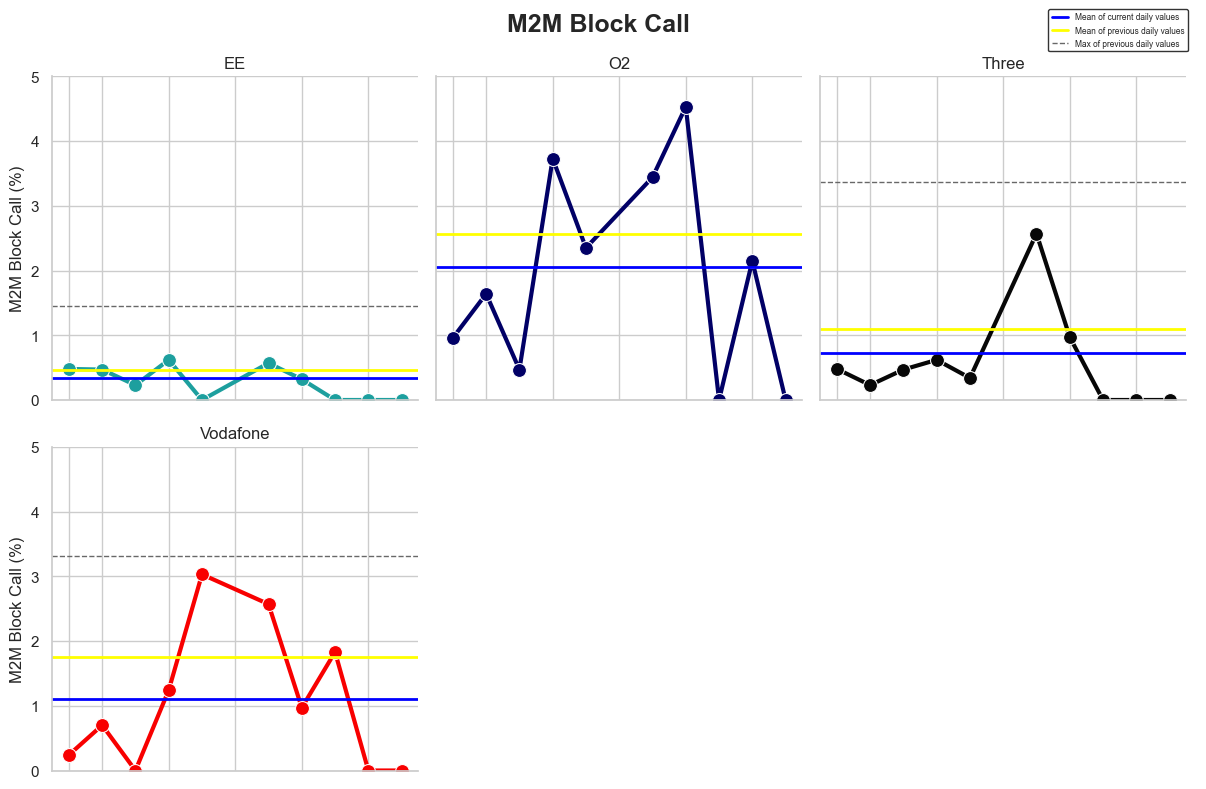

In [4326]:
def plot_with_call_block(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily block percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="block_pct",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = block_all_curr[block_all_curr['carrier'] == carrier]['block_rate_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = block_all_comp[block_all_comp['carrier'] == carrier]['block_rate_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    carrier_vals = block_comp[block_comp['carrier'] == carrier]['block_pct']
    if not carrier_vals.empty:
        max_val = carrier_vals.max()
        plt.axhline(
            y=max_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    block_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_call_block)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "M2M Block Call (%)")
g.set(ylim=(0, 5))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") 

plt.subplots_adjust(top=0.9)
g.fig.suptitle("M2M Block Call", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
max_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Max of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, max_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()


Compute EOM table

In [4327]:
#Merge and select columns
block_rate = pd.merge(block_all_curr, block_all_comp, on='carrier', how='outer')

block_rate = block_rate.drop(columns=['block_count_x', 'block_count_y', 'total_tests_x', 'total_tests_y'])

#Delta
block_rate['delta'] = (block_rate['block_rate_curr'] - block_rate['block_rate_comp'])

#Calculate percentage change
block_rate['pct_change'] = round(((block_rate['block_rate_curr'] - block_rate['block_rate_comp']) / block_rate['block_rate_comp']) * 100, 2)

#Add measure column
block_rate['measure'] = 'M2M Blocked Call (%)'

#Reorder columns
block_rate = block_rate[['measure', 'carrier', 'block_rate_curr', 'block_rate_comp', 'delta', 'pct_change']]

#Rename columns
block_rate = block_rate.rename(columns={
    'mean_LTE_curr': 'current',
    'mean_LTE_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

block_rate.head()

,measure,carrier,block_rate_curr,block_rate_comp,delta,% pct_change
0,M2M Blocked Call (%),EE,0.34,0.47,-0.13,-27.66
1,M2M Blocked Call (%),O2,2.05,2.56,-0.51,-19.92
2,M2M Blocked Call (%),Three,0.72,1.09,-0.37,-33.94
3,M2M Blocked Call (%),Vodafone,1.10,1.75,-0.65,-37.14


                                                Mobile-to-Mobile Call Drop

In [4328]:
call_data_curr['blocked_call'] = 0
mask =(call_data_curr['flag_access_success'] == False)
call_data_curr.loc[mask, 'blocked_call'] = 1

call_data_curr['dropped_call'] = 0
mask = (call_data_curr['flag_task_success'] == False)
call_data_curr.loc[mask, 'dropped_call'] = 1

call_data_curr['incomplete_call'] = 0
mask = (call_data_curr['flag_access_success'] == True) & \
       (call_data_curr['flag_task_success'] == None)
call_data_curr.loc[mask, 'incomplete_call'] = 1

# filter curr
filtered_call_drop_curr = (
    call_data_curr['dropped_call'] == 1
)

filtered_call_not_block_curr = (
    call_data_curr['blocked_call'] != 1
)

filtered_call_not_incomplete_curr = (
    call_data_curr['incomplete_call'] != 1
)

#comparison data

call_data_comp['blocked_call'] = 0
mask =(call_data_comp['flag_access_success'] == False)
call_data_comp.loc[mask, 'blocked_call'] = 1


call_data_comp['dropped_call'] = 0
mask = (call_data_comp['flag_task_success'] == False)
call_data_comp.loc[mask, 'dropped_call'] = 1

call_data_comp['incomplete_call'] = 0
mask = (call_data_comp['flag_access_success'] == True) & \
       (call_data_comp['flag_task_success'] == None)
call_data_comp.loc[mask, 'incomplete_call'] = 1

# filter comp
filtered_call_drop_comp = (
    call_data_comp['dropped_call'] == 1
)

filtered_call_not_block_comp = (
    call_data_comp['blocked_call'] != 1
)

filtered_call_not_incomplete_comp = (
    call_data_comp['incomplete_call'] != 1
)

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/338905326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['blocked_call'] = 0
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/338905326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_data_curr['dropped_call'] = 0
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/338905326.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Current:

In [4329]:
drop_1 = (
    call_data_curr[filtered_call_drop_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_2 = (
    call_data_curr[filtered_call_not_block_curr & filtered_call_not_incomplete_curr]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_curr = pd.merge(drop_1, drop_2, on=['carrier', 'start_date'], how='right').fillna(0)

drop_curr['drop_pct'] = round((drop_curr['drop_count'] / drop_curr['total_tests']) * 100, 2)

drop_curr = drop_curr[['carrier', 'start_date', 'drop_count', 'total_tests', 'drop_pct']]

# drop_curr.head()

Comparison:

In [4330]:
drop_3 = (
    call_data_comp[filtered_call_drop_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_4 = (
    call_data_comp[filtered_call_not_block_comp & filtered_call_not_incomplete_comp]
    .groupby(['carrier', 'start_date'], dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_comp = pd.merge(drop_3, drop_4, on=['carrier', 'start_date'], how='right').fillna(0)

drop_comp['drop_pct'] = round((drop_comp['drop_count'] / drop_comp['total_tests']) * 100, 2)

drop_comp = drop_comp[['carrier', 'start_date', 'drop_count', 'total_tests', 'drop_pct']]

# drop_comp.head()

                                                        M2M drop Rate Comparison market Overall

Current:

In [4331]:
drop_5 = (
    call_data_curr[filtered_call_drop_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_6 = (
    call_data_curr[filtered_call_not_block_curr & filtered_call_not_incomplete_curr]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_all_curr = pd.merge(drop_5, drop_6, on=['carrier'], how='right').fillna(0)

drop_all_curr['drop_rate_curr'] = round((drop_all_curr['drop_count'] / drop_all_curr['total_tests']) * 100, 2)

# Reorder the columns
drop_all_curr = drop_all_curr[['carrier', 'drop_count', 'total_tests', 'drop_rate_curr']]

# drop_all_curr.head()

Comparison

In [4332]:
drop_7 = (
    call_data_comp[filtered_call_drop_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='drop_count')
)

drop_8 = (
    call_data_comp[filtered_call_not_block_comp & filtered_call_not_incomplete_comp]
    .groupby('carrier', dropna=False)
    .size()
    .reset_index(name='total_tests')
)

drop_all_comp = pd.merge(drop_7, drop_8, on=['carrier'], how='right').fillna(0)

drop_all_comp['drop_rate_comp'] = round((drop_all_comp['drop_count'] / drop_all_comp['total_tests']) * 100, 2)

# Reorder the columns
drop_all_comp = drop_all_comp[['carrier', 'drop_count', 'total_tests', 'drop_rate_comp']]

# drop_all_comp.head()

PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2070678131.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


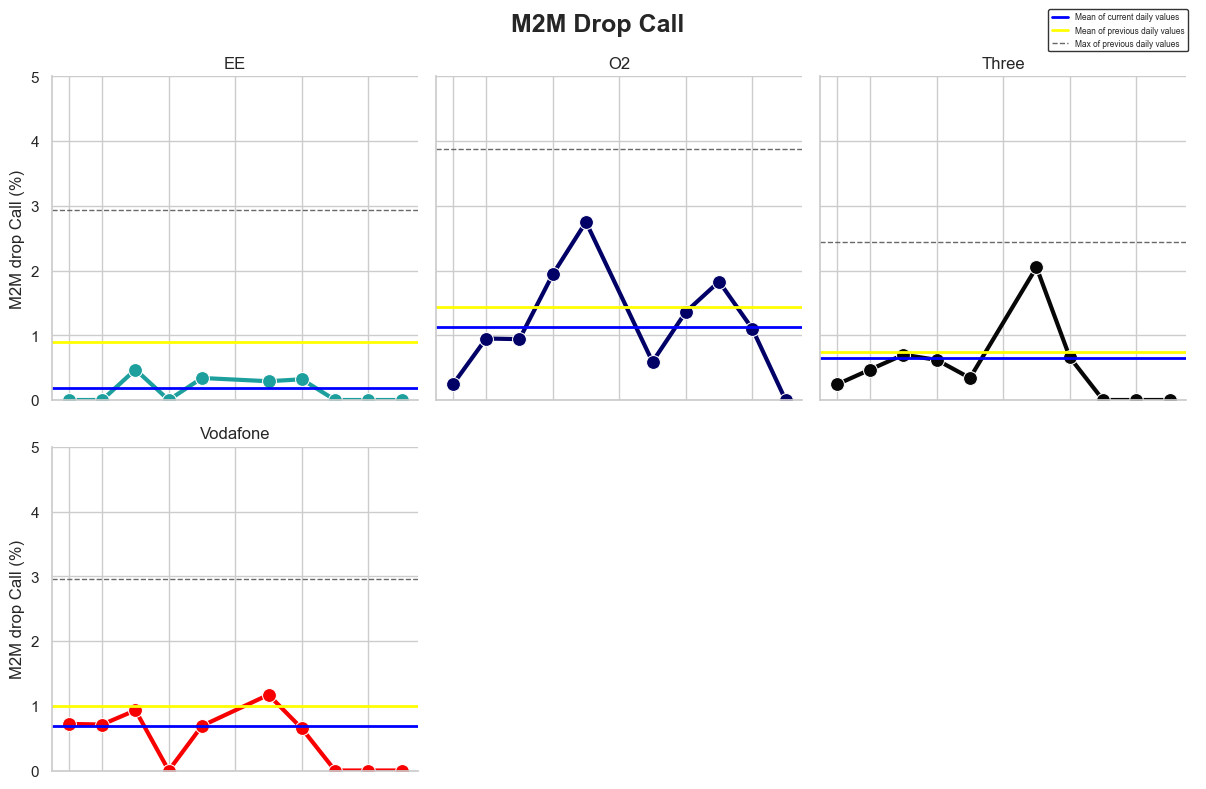

In [4333]:
def plot_with_call_drop(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily drop percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="drop_pct",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = drop_all_curr[drop_all_curr['carrier'] == carrier]['drop_rate_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = drop_all_comp[drop_all_comp['carrier'] == carrier]['drop_rate_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    carrier_vals = drop_comp[drop_comp['carrier'] == carrier]['drop_pct']
    if not carrier_vals.empty:
        max_val = carrier_vals.max()
        plt.axhline(
            y=max_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    drop_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_call_drop)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "M2M drop Call (%)")
g.set(ylim=(0, 5))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") 

plt.subplots_adjust(top=0.9)
g.fig.suptitle("M2M Drop Call", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
max_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Max of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, max_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()


Compute EOM table

In [4334]:
#Merge and select columns
drop_rate = pd.merge(drop_all_curr, drop_all_comp, on='carrier', how='outer')

drop_rate = drop_rate.drop(columns=['drop_count_x', 'drop_count_y', 'total_tests_x', 'total_tests_y'])

#Delta
drop_rate['delta'] = (drop_rate['drop_rate_curr'] - drop_rate['drop_rate_comp'])

#Calculate percentage change
drop_rate['pct_change'] = round(((drop_rate['drop_rate_curr'] - drop_rate['drop_rate_comp']) / drop_rate['drop_rate_comp']) * 100, 2)

#Add measure column
drop_rate['measure'] = 'M2M Droped Call (%)'

#Reorder columns
drop_rate = drop_rate[['measure', 'carrier', 'drop_rate_curr', 'drop_rate_comp', 'delta', 'pct_change']]

#Rename columns
drop_rate = drop_rate.rename(columns={
    'mean_LTE_curr': 'current',
    'mean_LTE_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

drop_rate.head()

,measure,carrier,drop_rate_curr,drop_rate_comp,delta,% pct_change
0,M2M Droped Call (%),EE,0.19,0.90,-0.71,-78.89
1,M2M Droped Call (%),O2,1.13,1.43,-0.30,-20.98
2,M2M Droped Call (%),Three,0.65,0.74,-0.09,-12.16
3,M2M Droped Call (%),Vodafone,0.69,0.99,-0.30,-30.30


                                            Download Throughput

In [4335]:
##Current
# Filter rows
filtered_dl_tput_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]

# Convert to date
filtered_dl_tput_curr['start_date'] = pd.to_datetime(filtered_dl_tput_curr['local_time']).dt.date

# Convert download speed to Mbps (kbit/s ÷ 1000)
filtered_dl_tput_curr['download_mbps'] = filtered_dl_tput_curr['dsd_effective_download_test_speed'] / 1000

##Comparison:
# Filter rows
filtered_dl_tput_comp = df_ts_comp[df_ts_comp['test_type_id'] == 20]

# Convert to date
filtered_dl_tput_comp['start_date'] = pd.to_datetime(filtered_dl_tput_comp['local_time']).dt.date

# Convert download speed to Mbps (kbit/s ÷ 1000)
filtered_dl_tput_comp['download_mbps'] = filtered_dl_tput_comp['dsd_effective_download_test_speed'] / 1000

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1413940453.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_tput_curr['start_date'] = pd.to_datetime(filtered_dl_tput_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1413940453.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_tput_curr['download_mbps'] = filtered_dl_tput_curr['dsd_effective_download_test_speed'] / 1000
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ip

Current:

In [4336]:
dl_tput_curr = (
    filtered_dl_tput_curr
    .groupby(['carrier', 'start_date'], as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'median_dl_tput_curr'})
)

dl_tput_curr['median_dl_tput_curr'] = dl_tput_curr['median_dl_tput_curr'].round(2)

# dl_tput_curr.head()

Comparison:

In [4337]:
dl_tput_comp = (
    filtered_dl_tput_comp
    .groupby(['carrier', 'start_date'], as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'median_dl_tput_comp'})
)

dl_tput_comp['median_dl_tput_comp'] = dl_tput_comp['median_dl_tput_comp'].round(2)

# dl_tput_comp.head()

Current:

In [4338]:
dl_tput_all_curr = (
    filtered_dl_tput_curr
    .groupby('carrier', as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'dl_tput_curr_line'})
)

dl_tput_all_curr['dl_tput_curr_line'] = dl_tput_all_curr['dl_tput_curr_line'].round(2)

# dl_tput_all_curr.head()

Comparison:

In [4339]:
dl_tput_all_comp = (
    filtered_dl_tput_comp
    .groupby('carrier', as_index=False)['download_mbps']
    .median()
    .rename(columns={'download_mbps': 'dl_tput_comp_line'})
)

dl_tput_all_comp['dl_tput_comp_line'] = dl_tput_all_comp['dl_tput_comp_line'].round(2)

# dl_tput_all_comp.head()

PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1901210197.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


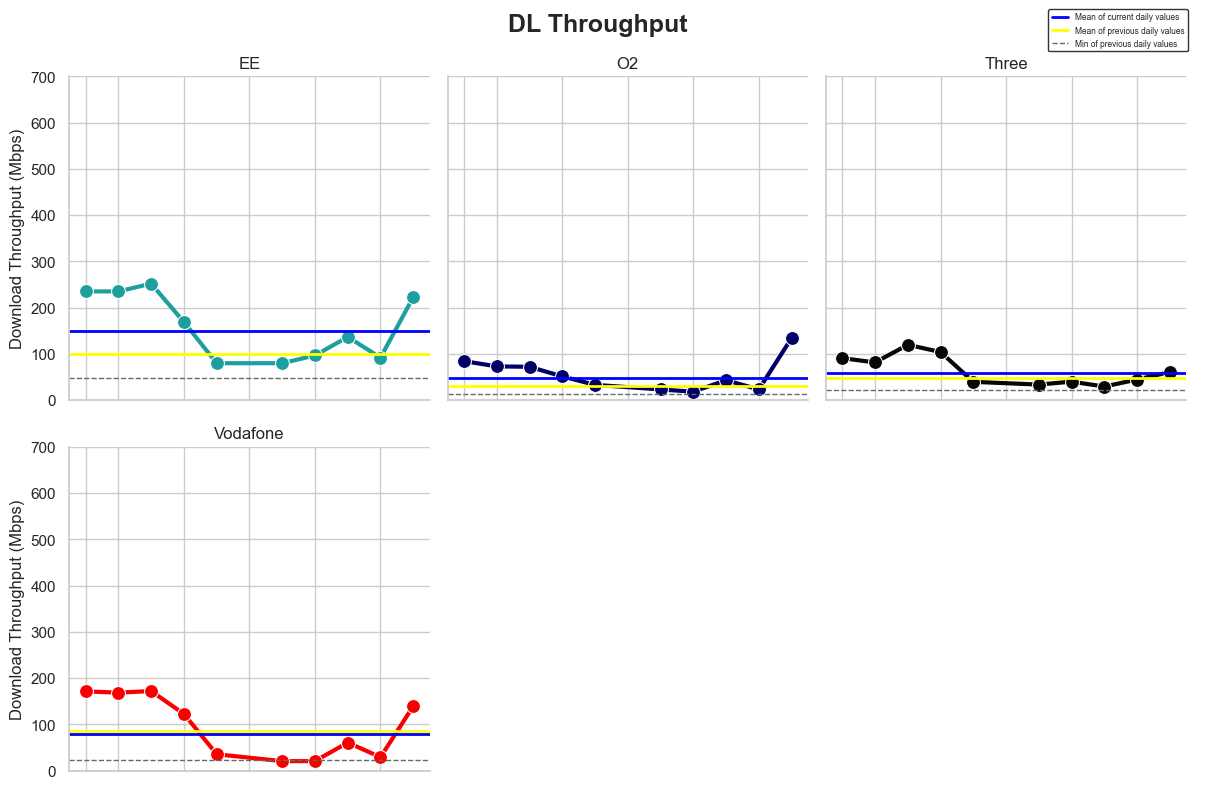

In [4340]:
def plot_with_dl_tput(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily DL percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="median_dl_tput_curr",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = dl_tput_all_curr[dl_tput_all_curr['carrier'] == carrier]['dl_tput_curr_line']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = dl_tput_all_comp[dl_tput_all_comp['carrier'] == carrier]['dl_tput_comp_line']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = dl_tput_comp[dl_tput_comp['carrier'] == carrier]['median_dl_tput_comp']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    dl_tput_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_dl_tput)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "Download Throughput (Mbps)")
g.set(ylim=(0, 700))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("DL Throughput", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()

compute EOM table

In [4341]:
#Merge and select columns
dl_tput = pd.merge(dl_tput_all_curr, dl_tput_all_comp, on='carrier', how='outer')


#Delta
dl_tput['delta'] = (dl_tput['dl_tput_curr_line'] - dl_tput['dl_tput_comp_line'])

#Calculate percentage change
dl_tput['pct_change'] = round(((dl_tput['dl_tput_curr_line'] - dl_tput['dl_tput_comp_line']) / dl_tput['dl_tput_comp_line']) * 100, 2)

# #Add measure column
dl_tput['measure'] = 'DL Throughput (Mbps)'

#Reorder columns
dl_tput = dl_tput[['measure', 'carrier', 'dl_tput_curr_line', 'dl_tput_comp_line', 'delta', 'pct_change']]

#Rename columns
dl_tput = dl_tput.rename(columns={
    'dl_tput_curr_line': 'current',
    'dl_tput_comp_line': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

dl_tput.head()

,measure,carrier,current,comparison,delta,% pct_change
0,DL Throughput (Mbps),EE,149.69,98.81,50.88,51.49
1,DL Throughput (Mbps),O2,47.22,30.57,16.65,54.47
2,DL Throughput (Mbps),Three,58.00,47.76,10.24,21.44
3,DL Throughput (Mbps),Vodafone,78.67,85.37,-6.70,-7.85


                                                    Upload Throughput

In [4342]:
filtered_ul_tput_curr = df_ts_curr[df_ts_curr['test_type_id'] == 19]
filtered_ul_tput_curr['start_date'] = pd.to_datetime(filtered_ul_tput_curr['local_time']).dt.date
filtered_ul_tput_curr['upload_mbps'] = filtered_ul_tput_curr['dsu_effective_upload_test_speed'] / 1000

filtered_ul_tput_comp = df_ts_comp[df_ts_comp['test_type_id'] == 19]
filtered_ul_tput_comp['start_date'] = pd.to_datetime(filtered_ul_tput_comp['local_time']).dt.date
filtered_ul_tput_comp['upload_mbps'] = filtered_ul_tput_comp['dsu_effective_upload_test_speed'] / 1000

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2908335583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ul_tput_curr['start_date'] = pd.to_datetime(filtered_ul_tput_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2908335583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ul_tput_curr['upload_mbps'] = filtered_ul_tput_curr['dsu_effective_upload_test_speed'] / 1000
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipyker

Current:

In [4343]:
ul_tput_curr = (
    filtered_ul_tput_curr
    .groupby(['carrier', 'start_date'], as_index=False)['upload_mbps']
    .median()
    .rename(columns={'upload_mbps': 'median_ul_tput_curr'})
)
ul_tput_curr['median_ul_tput_curr'] = ul_tput_curr['median_ul_tput_curr'].round(2)

# ul_tput_curr.head()

Comparison:

In [4344]:
ul_tput_comp = (
    filtered_ul_tput_comp
    .groupby(['carrier', 'start_date'], as_index=False)['upload_mbps']
    .median()
    .rename(columns={'upload_mbps': 'median_ul_tput_comp'})
)
ul_tput_comp['median_ul_tput_comp'] = ul_tput_comp['median_ul_tput_comp'].round(2)

# ul_tput_comp.head()

                                                    ALL

Current:

In [4345]:
ul_tput_all_curr = (
    filtered_ul_tput_curr
    .groupby('carrier', as_index=False)['upload_mbps']
    .median()
    .rename(columns={'upload_mbps': 'ul_tput_curr_line'})
)
ul_tput_all_curr['ul_tput_curr_line'] = ul_tput_all_curr['ul_tput_curr_line'].round(2)

# ul_tput_all_curr.head()

Comparison:

In [4346]:
ul_tput_all_comp = (
    filtered_ul_tput_comp
    .groupby('carrier', as_index=False)['upload_mbps']
    .median()
    .rename(columns={'upload_mbps': 'ul_tput_comp_line'})
)
ul_tput_all_comp['ul_tput_comp_line'] = ul_tput_all_comp['ul_tput_comp_line'].round(2)

# ul_tput_all_comp.head()

PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/4098718903.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


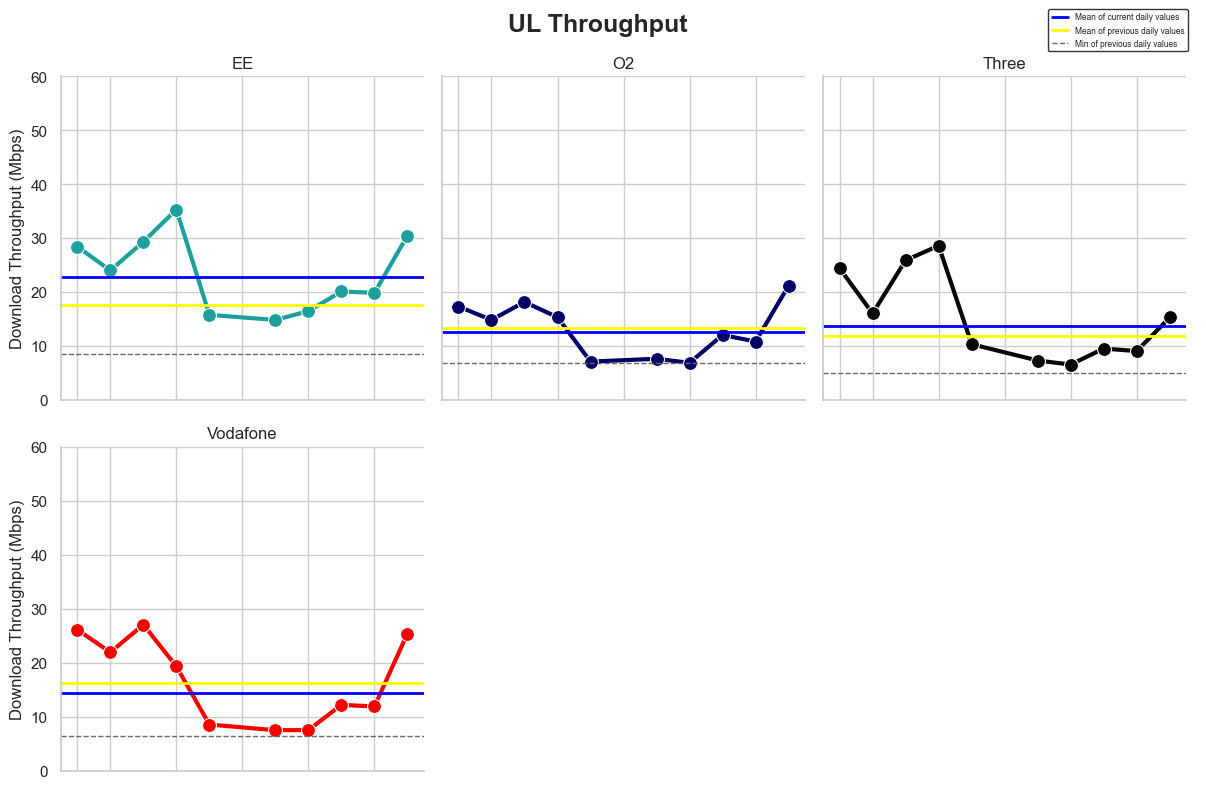

In [4347]:
def plot_with_ul_tput(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily ul percentage
    sns.lineplot(
        data=data,
        x="start_date",
        y="median_ul_tput_curr",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = ul_tput_all_curr[ul_tput_all_curr['carrier'] == carrier]['ul_tput_curr_line']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = ul_tput_all_comp[ul_tput_all_comp['carrier'] == carrier]['ul_tput_comp_line']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = ul_tput_comp[ul_tput_comp['carrier'] == carrier]['median_ul_tput_comp']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    ul_tput_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_ul_tput)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "Download Throughput (Mbps)")
g.set(ylim=(0, 60))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("UL Throughput", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()

compute EOM table

In [4348]:
#Merge and select columns
ul_tput = pd.merge(ul_tput_all_curr, ul_tput_all_comp, on='carrier', how='outer')

#Delta
ul_tput['delta'] = (ul_tput['ul_tput_curr_line'] - ul_tput['ul_tput_comp_line'])

#Calculate percentage change
ul_tput['pct_change'] = round(((ul_tput['ul_tput_curr_line'] - ul_tput['ul_tput_comp_line']) / ul_tput['ul_tput_comp_line']) * 100, 2)

# #Add measure column
ul_tput['measure'] = 'UL Throughput (Mbps)'

#Reorder columns
ul_tput = ul_tput[['measure', 'carrier', 'ul_tput_curr_line', 'ul_tput_comp_line', 'delta', 'pct_change']]

#Rename columns
ul_tput = ul_tput.rename(columns={
    'ul_tput_curr_line': 'current',
    'ul_tput_comp_line': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

ul_tput.head()

,measure,carrier,current,comparison,delta,% pct_change
0,UL Throughput (Mbps),EE,22.87,17.64,5.23,29.65
1,UL Throughput (Mbps),O2,12.59,13.29,-0.70,-5.27
2,UL Throughput (Mbps),Three,13.80,11.81,1.99,16.85
3,UL Throughput (Mbps),Vodafone,14.35,16.21,-1.86,-11.47


                                                Download Access Success

In [4349]:
filtered_dl_acc_succ_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]
filtered_dl_acc_succ_curr['start_date'] = pd.to_datetime(filtered_dl_acc_succ_curr['local_time']).dt.date
filtered_dl_acc_succ_curr['percentage_access_success'] = filtered_dl_acc_succ_curr['percentage_access_success'] * 100


filtered_dl_acc_succ_comp = df_ts_comp[df_ts_comp['test_type_id'] == 20]
filtered_dl_acc_succ_comp['start_date'] = pd.to_datetime(filtered_dl_acc_succ_comp['local_time']).dt.date
filtered_dl_acc_succ_comp['percentage_access_success'] = filtered_dl_acc_succ_comp['percentage_access_success'] * 100

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/3522016850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_acc_succ_curr['start_date'] = pd.to_datetime(filtered_dl_acc_succ_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/3522016850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_acc_succ_curr['percentage_access_success'] = filtered_dl_acc_succ_curr['percentage_access_success'] * 100
/var/folders/bp/rq20yws14k3dmzd9

In [4350]:
dl_acc_curr = (
    filtered_dl_acc_succ_curr
    .groupby(['carrier', 'start_date'], as_index=False)['percentage_access_success']
    .mean()
    .rename(columns={'percentage_access_success': 'avg_dl_acc'})
)

dl_acc_curr['avg_dl_acc'] = dl_acc_curr['avg_dl_acc'].round(2)

# dl_acc_curr.head()

ul_tput_curr<- as.data.frame (ts_curr %>% 
                                filter(test_type_id==19) %>% 
                                group_by(carrier, start_date = as.Date(format(local_time,"%Y-%m-%d"))) %>%
                                summarise(median_ul_tput_curr = round(median(dsu_effective_upload_test_speed, na.rm = TRUE)/1000,digits = 2)))

In [4351]:
dl_acc_comp = (
    filtered_dl_acc_succ_comp
    .groupby(['carrier', 'start_date'], as_index=False)['percentage_access_success']
    .mean()
    .rename(columns={'percentage_access_success': 'avg_dl_acc'})
)

dl_acc_comp['avg_dl_acc'] = dl_acc_comp['avg_dl_acc'].round(2)

# dl_acc_comp.head()

                                                                ALL

Current:

In [4352]:
dl_all_acc_curr = (
    filtered_dl_acc_succ_curr
    .groupby('carrier', as_index=False)['percentage_access_success']
    .mean()
    .rename(columns={'percentage_access_success': 'avg_dl_acc_curr'})
)

dl_all_acc_curr['avg_dl_acc_curr'] = dl_all_acc_curr['avg_dl_acc_curr'].round(2)

# dl_all_acc_curr.head()

Comparison:

In [4353]:
dl_all_acc_comp = (
    filtered_dl_acc_succ_comp
    .groupby('carrier', as_index=False)['percentage_access_success']
    .mean()
    .rename(columns={'percentage_access_success': 'avg_dl_acc_comp'})
)

dl_all_acc_comp['avg_dl_acc_comp'] = dl_all_acc_comp['avg_dl_acc_comp'].round(2)

# dl_all_acc_comp.head()

PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/1788435202.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


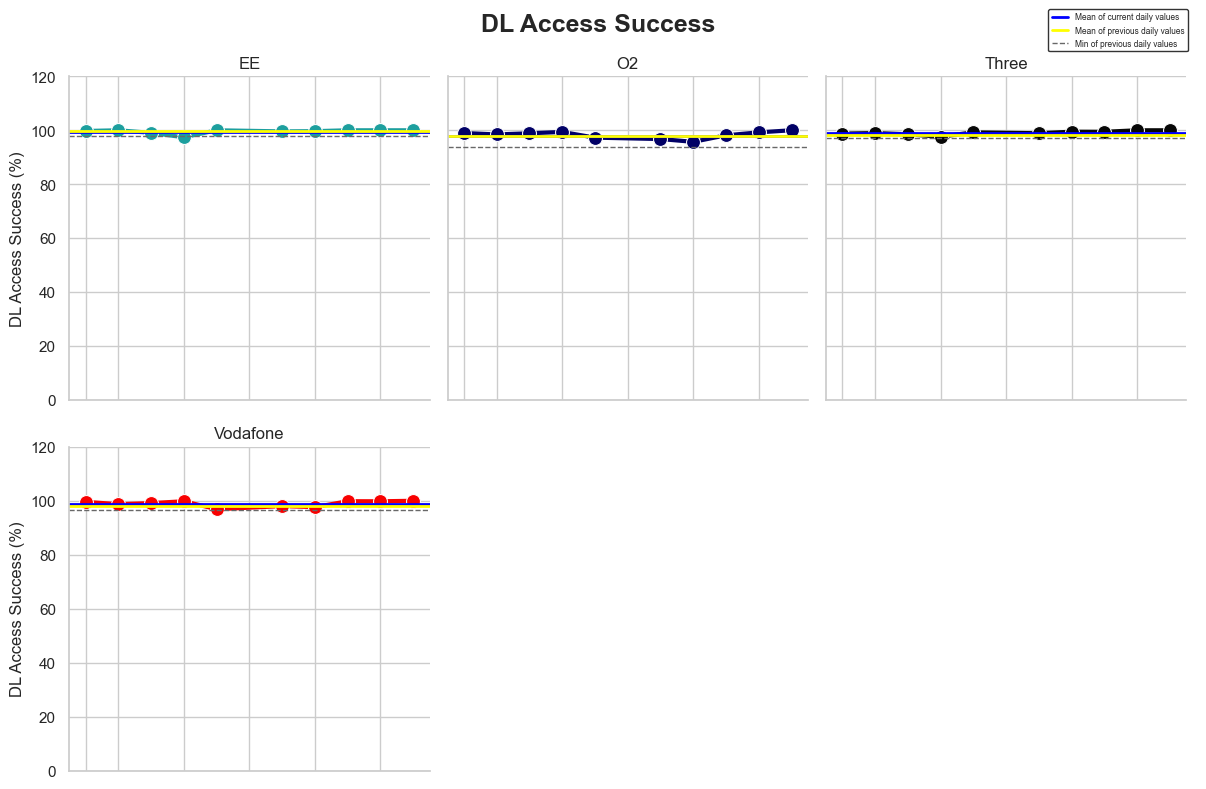

In [4354]:
def plot_with_dl_acc_succ(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily dl access success
    sns.lineplot(
        data=data,
        x="start_date",
        y="avg_dl_acc",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = dl_all_acc_curr[dl_all_acc_curr['carrier'] == carrier]['avg_dl_acc_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = dl_all_acc_comp[dl_all_acc_comp['carrier'] == carrier]['avg_dl_acc_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = dl_acc_comp[dl_acc_comp['carrier'] == carrier]['avg_dl_acc']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    dl_acc_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_dl_acc_succ)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "DL Access Success (%)")
g.set(ylim=(0, 120))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("DL Access Success", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()

compute EOM table

In [4355]:
#Merge and select columns
dl_acc = pd.merge(dl_all_acc_curr , dl_all_acc_comp, on='carrier', how='outer')

#Delta
dl_acc['delta'] = (dl_acc['avg_dl_acc_curr'] - dl_acc['avg_dl_acc_comp'])

#Calculate percentage change
dl_acc['pct_change'] = round(((dl_acc['avg_dl_acc_curr'] - dl_acc['avg_dl_acc_comp']) / dl_acc['avg_dl_acc_comp']) * 100, 2)

# #Add measure column
dl_acc['measure'] = 'DL Access Success (%)'

#Reorder columns
dl_acc = dl_acc[['measure', 'carrier', 'avg_dl_acc_curr', 'avg_dl_acc_comp', 'delta', 'pct_change']]

#Rename columns
dl_acc = dl_acc.rename(columns={
    'avg_dl_acc_curr': 'current',
    'avg_dl_acc_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

dl_acc.head()

,measure,carrier,current,comparison,delta,% pct_change
0,DL Access Success (%),EE,99.54,99.59,-0.05,-0.05
1,DL Access Success (%),O2,98.02,97.80,0.22,0.22
2,DL Access Success (%),Three,98.93,98.29,0.64,0.65
3,DL Access Success (%),Vodafone,98.67,98.20,0.47,0.48


                                                Download Task Success

In [4356]:
filtered_dl_task_succ_curr = df_ts_curr[df_ts_curr['test_type_id'] == 20]
filtered_dl_task_succ_curr['start_date'] = pd.to_datetime(filtered_dl_task_succ_curr['local_time']).dt.date
filtered_dl_task_succ_curr['percentage_task_success'] = filtered_dl_task_succ_curr['percentage_task_success'] * 100


filtered_dl_task_succ_comp = df_ts_comp[df_ts_comp['test_type_id'] == 20]
filtered_dl_task_succ_comp['start_date'] = pd.to_datetime(filtered_dl_task_succ_comp['local_time']).dt.date
filtered_dl_task_succ_comp['percentage_task_success'] = filtered_dl_task_succ_comp['percentage_task_success'] * 100

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2313656264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_task_succ_curr['start_date'] = pd.to_datetime(filtered_dl_task_succ_curr['local_time']).dt.date
/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2313656264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dl_task_succ_curr['percentage_task_success'] = filtered_dl_task_succ_curr['percentage_task_success'] * 100
/var/folders/bp/rq20yws14k3dmzd9

In [4357]:
dl_task_curr = (
    filtered_dl_task_succ_curr
    .groupby(['carrier', 'start_date'], as_index=False)['percentage_task_success']
    .mean()
    .rename(columns={'percentage_task_success': 'avg_dl_task'})
)

dl_task_curr['avg_dl_task'] = dl_task_curr['avg_dl_task'].round(2)

# dl_task_curr.head()

In [4358]:
dl_task_comp = (
    filtered_dl_task_succ_comp
    .groupby(['carrier', 'start_date'], as_index=False)['percentage_task_success']
    .mean()
    .rename(columns={'percentage_task_success': 'avg_dl_task'})
)

dl_task_comp['avg_dl_task'] = dl_task_comp['avg_dl_task'].round(2)

# dl_task_comp.head()

                                                                ALL

In [4359]:
dl_all_task_curr = (
    filtered_dl_task_succ_curr
    .groupby('carrier', as_index=False)['percentage_task_success']
    .mean()
    .rename(columns={'percentage_task_success': 'avg_dl_task_curr'})
)

dl_all_task_curr['avg_dl_task_curr'] = dl_all_task_curr['avg_dl_task_curr'].round(2)

# dl_all_task_curr.head()

In [4360]:
dl_all_task_comp = (
    filtered_dl_task_succ_comp
    .groupby('carrier', as_index=False)['percentage_task_success']
    .mean()
    .rename(columns={'percentage_task_success': 'avg_dl_task_comp'})
)

dl_all_task_comp['avg_dl_task_comp'] = dl_all_task_comp['avg_dl_task_comp'].round(2)

# dl_all_task_comp.head()

PLOT

/var/folders/bp/rq20yws14k3dmzd9x85_85th0000gp/T/ipykernel_53277/2740757891.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


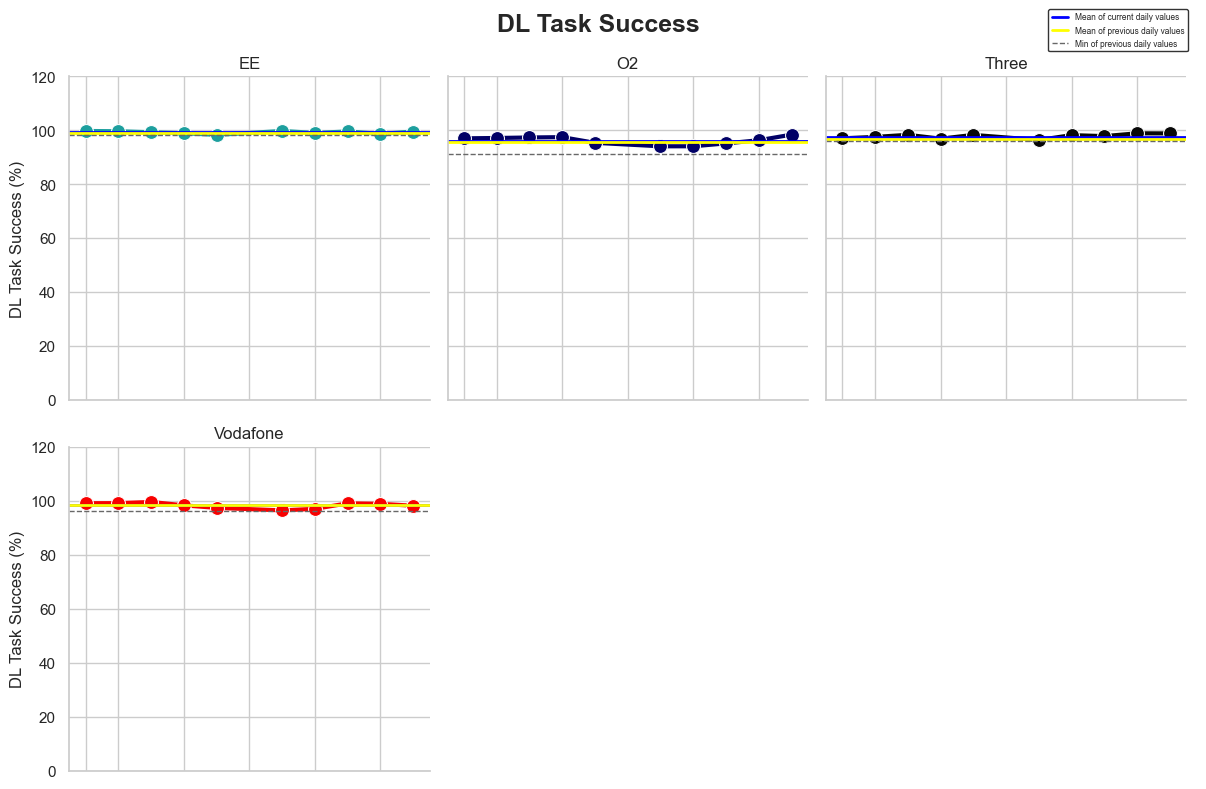

In [4361]:
def plot_with_dl_task_succ(data, color, **kwargs):
    import matplotlib.pyplot as plt

    carrier = data['carrier'].iloc[0]  

    # Plot the line for daily dl task success
    sns.lineplot(
        data=data,
        x="start_date",
        y="avg_dl_task",
        marker="o",
        color=carrier_color_dict_reporting.get(carrier, "gray"),
        linewidth=3,
        markersize=10,
        **kwargs
    )

    # Add summary lines
    mean_curr_vals = dl_all_task_curr[dl_all_task_curr['carrier'] == carrier]['avg_dl_task_curr']
    if not mean_curr_vals.empty:
        mean_curr = mean_curr_vals.mean()
        plt.axhline(
            y=mean_curr,
            color="blue",
            linewidth=2,
            linestyle="-"
        )

    mean_comp_vals = dl_all_task_comp[dl_all_task_comp['carrier'] == carrier]['avg_dl_task_comp']
    if not mean_comp_vals.empty:
        mean_comp = mean_comp_vals.mean()
        plt.axhline(
            y=mean_comp,
            color="yellow",
            linewidth=2,
            linestyle="-"
        )

    min_vals = dl_task_comp[dl_task_comp['carrier'] == carrier]['avg_dl_task']
    if not min_vals.empty:
        min_val = min_vals.min()
        plt.axhline(
            y=min_val,
            color="#686868",
            linewidth=1,
            linestyle="dashed"
        )

g = sns.FacetGrid(
    dl_task_curr,
    col="carrier",
    col_wrap=3,
    height=4,
    sharey=True
)

g.map_dataframe(plot_with_dl_task_succ)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "DL Task Success (%)")
g.set(ylim=(0, 120))

# Adjust the x-axis tick labels (dates)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=8)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("DL Task Success", fontsize=18, fontweight="bold")


# Create custom legend handles
mean_curr_line = mlines.Line2D([], [], color='blue', linewidth=2, label='Mean of current daily values')
mean_comp_line = mlines.Line2D([], [], color='yellow', linewidth=2, label='Mean of previous daily values')
min_comp_line = mlines.Line2D([], [], color='#686868', linewidth=1, linestyle='dashed', label='Min of previous daily values')

# Add to the figure legend (not individual subplots)
g.add_legend()  
g.fig.legend(
    handles=[mean_curr_line, mean_comp_line, min_comp_line],
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,
    frameon=True,
    edgecolor='black'
)
plt.tight_layout()
plt.show()

compute EOM table

In [4362]:
#Merge and select columns
dl_task = pd.merge(dl_all_task_curr , dl_all_task_comp, on='carrier', how='outer')

#Delta
dl_task['delta'] = (dl_task['avg_dl_task_curr'] - dl_task['avg_dl_task_comp'])

#Calculate percentage change
dl_task['pct_change'] = round(((dl_task['avg_dl_task_curr'] - dl_task['avg_dl_task_comp']) / dl_task['avg_dl_task_comp']) * 100, 2)

# #Add measure column
dl_task['measure'] = 'DL Task Success (%)'

#Reorder columns
dl_task = dl_task[['measure', 'carrier', 'avg_dl_task_curr', 'avg_dl_task_comp', 'delta', 'pct_change']]

#Rename columns
dl_task = dl_task.rename(columns={
    'avg_dl_task_curr': 'current',
    'avg_dl_task_comp': 'comparison',
    'delta': 'delta',
    'pct_change': '% pct_change'
})

dl_task.head()

,measure,carrier,current,comparison,delta,% pct_change
0,DL Task Success (%),EE,99.29,99.17,0.12,0.12
1,DL Task Success (%),O2,96.10,95.81,0.29,0.30
2,DL Task Success (%),Three,97.62,96.75,0.87,0.90
3,DL Task Success (%),Vodafone,98.30,98.38,-0.08,-0.08


In [4363]:
print("Notable Insights: \n*DL 5G \n*M2M block/drop \n*Median DL/UL throughput " \
"\n\nOther Observations: \n*Access success \n*Task Success rates " \
"\n\nData Exclusion/Tracking Items: \n*Excluded test(s) due to device issue: None \n*Other manual exclusions performed: None")



Notable Insights: 
*DL 5G 
*M2M block/drop 
*Median DL/UL throughput 

Other Observations: 
*Access success 
*Task Success rates 

Data Exclusion/Tracking Items: 
*Excluded test(s) due to device issue: None 
*Other manual exclusions performed: None


    DQ Test Counts

In [4364]:
print("DQ Test Counts: ")

df_test_count.head(len(df_test_count))

DQ Test Counts: 


,column0,column1,column2,column3,column4,column5
0,00,-------- DQ Test Counts --------,,,,
1,01,London-UK_2025-1H (CSID: 12854),,,,
2,02,,,,,
3,03,*****Total Test Count*****,Reportable,Valid,Invalid,Excluded Data
4,04,,93069,94592,3,1523
5,05,,,,,
6,06,*****Report Set*****,Reportable,Valid,Invalid,Excluded Data
7,07,EE,23279,23652,1,373
8,07,O2,23269,23649,0,380
9,07,Three,23269,23640,2,371
